<a href="https://colab.research.google.com/github/vrjpt10/Cleaning-and-Exploring-Big-Data-using-PySpark/blob/main/Cleaning_and_Exploring_Big_Data_using_PySparkipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Spark, download datasets, create final dataframe.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop2.7.tgz
!tar xf spark-3.1.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop2.7"
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
!wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
!wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

--2023-01-05 22:53:49--  https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.224.160, 52.217.233.232, 52.216.138.85, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.224.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20069199 (19M) [text/csv]
Saving to: ‘features.csv’

features.csv        100%[===================>]  19.14M  22.5MB/s    in 0.8s    

2023-01-05 22:53:51 (22.5 MB/s) - ‘features.csv’ saved [20069199/20069199]

--2023-01-05 22:53:51--  https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.224.160, 52.217.233.232, 52.216.138.85, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.224.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148327 (1.1M) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[====

In [4]:
!ls

features.csv  sample_data		 spark-3.1.3-bin-hadoop2.7.tgz
labels.csv    spark-3.1.3-bin-hadoop2.7


Create spark session locally

In [5]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
# Load dataset
feature = sc.read.csv("features.csv",inferSchema = True, header = True)
label = sc.read.csv("labels.csv",inferSchema = True, header = True)

In [7]:
print(feature.count())
print(label.count())
print(feature.columns)
print(label.columns)

59400
59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
['id', 'status_group']


In [8]:
data = feature.join(label, on = ("id"))
print(data.count())
print(data.columns)

59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


Change column type, drop duplicated rows, remove whitespacs.

In [9]:
print(data.printSchema())
print(data.show())

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable = 

In [10]:
data = data.withColumn('region_code',col('region_code').cast(StringType())).withColumn('district_code', col('district_code').cast(StringType()))


In [11]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: string (nullable = true)
 |-- district_code: string (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable = tr

In [12]:
# check if there's any duplicate entry and remove if any
data = data.dropDuplicates(["id"])
data.count()

59400

In [13]:
# remove leading and traing spaces from columns
str_cols = [item[0] for item in data.dtypes if item[1].startswith('string')]
for cols in str_cols:
  data = data.withColumn(cols,trim(data[cols]))

Remove columns with null values more than a threshold. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [14]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit',}]).show()

+---+----------+------+----------+---------+---------+--------+--------+-----------+-----+----------+------+-----------+-------------+---+----+----------+-----------+-----------------+-----------+-----------------+---------------+---------------------+---------------------+----------+----------------+-------+------------+-------------+-------------+--------+--------------+------+-----------+------------+---------------+---------------------+------------+
| id|amount_tsh|funder|gps_height|installer|longitude|latitude|wpt_name|num_private|basin|subvillage|region|region_code|district_code|lga|ward|population|recorded_by|scheme_management|scheme_name|construction_year|extraction_type|extraction_type_group|extraction_type_class|management|management_group|payment|payment_type|water_quality|quality_group|quantity|quantity_group|source|source_type|source_class|waterpoint_type|waterpoint_type_group|status_group|
+---+----------+------+----------+---------+---------+--------+--------+----------

In [15]:
# get the average number of null values in each column
agg_row = data.select([(count(when(isnan(c) | col(c).isNull(), c))/data.count()).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit',}]).collect()

In [16]:
# convert agg_row to dictionary for easy iteration
agg_dict_list = [row.asDict() for row in agg_row]
agg_dict = agg_dict_list[0]

In [17]:
# list of those columns whose average null value is greater than 0.4
col_null = list({i for i in agg_dict if agg_dict[i] > 0.4})
print(agg_dict)
print(col_null)
data = data.drop(*col_null)

{'id': 0.0, 'amount_tsh': 0.0, 'funder': 0.0611952861952862, 'gps_height': 0.0, 'installer': 0.061531986531986535, 'longitude': 0.0, 'latitude': 0.0, 'wpt_name': 0.0, 'num_private': 0.0, 'basin': 0.0, 'subvillage': 0.0062457912457912455, 'region': 0.0, 'region_code': 0.0, 'district_code': 0.0, 'lga': 0.0, 'ward': 0.0, 'population': 0.0, 'recorded_by': 0.0, 'scheme_management': 0.06526936026936027, 'scheme_name': 0.4741750841750842, 'construction_year': 0.0, 'extraction_type': 0.0, 'extraction_type_group': 0.0, 'extraction_type_class': 0.0, 'management': 0.0, 'management_group': 0.0, 'payment': 0.0, 'payment_type': 0.0, 'water_quality': 0.0, 'quality_group': 0.0, 'quantity': 0.0, 'quantity_group': 0.0, 'source': 0.0, 'source_type': 0.0, 'source_class': 0.0, 'waterpoint_type': 0.0, 'waterpoint_type_group': 0.0, 'status_group': 0.0}
['scheme_name']


Group, aggregate, create pivot table. 

In [18]:
data.groupBy('recorded_by').count().show()

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



In [19]:
data.groupBy('water_quality').count().orderBy('count', ascending = False).show()

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



In [20]:
data = data.drop('recorded_by')

In [21]:
# create pivot table grouped by status of the well in each region and calculate 
# the sum of total amount of water in the wells
data.groupBy('status_group').pivot('region').sum('amount_tsh').show()

+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|        status_group|   Arusha|Dar es Salaam|Dodoma|   Iringa|Kagera|  Kigoma|       Kilimanjaro|  Lindi| Manyara|    Mara|Mbeya|Morogoro| Mtwara| Mwanza|    Pwani|   Rukwa|   Ruvuma|Shinyanga| Singida|Tabora|   Tanga|
+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|functional needs ...|  10280.0|          0.0|   0.0| 118400.0|   0.0|270770.0|          129248.0| 3625.0| 71315.0|   900.0|  0.0| 70005.0|36240.0|10000.0|    520.0|292980.0| 125650.0|   2200.0|  6505.0|   0.0|  4310.0|
|          functional|1125485.0|     181175.0|   0.0|5515710.0|   0.0|530725.0|         746942.25|24560.0|312745.0| 9678

Convert categories with low frequency to Others, impute missing values.

In [22]:
print(str_cols)

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [23]:
# print current categories and their frequencies in descending order
for column in str_cols[:3]:
  print(data.groupBy(column).count().orderBy('count', ascending = False).show())
  values_cat = data.groupBy(column).count().collect()
  lessthan =[x[0] for x in values_cat if x[1] < 1000]
  data = data.withColumn(column,when(col(column).isin(lessthan), 'Others').otherwise(col(column)))
  data.groupBy(column).count().orderBy('count', ascending = False).show()

+-------------+-----+
|date_recorded|count|
+-------------+-----+
|   2011-03-15|  572|
|   2011-03-17|  558|
|   2013-02-03|  546|
|   2011-03-14|  520|
|   2011-03-16|  513|
|   2011-03-18|  497|
|   2011-03-19|  466|
|   2013-02-04|  464|
|   2013-01-29|  459|
|   2011-03-04|  458|
|   2013-02-14|  444|
|   2013-01-24|  435|
|   2011-03-05|  434|
|   2013-02-15|  429|
|   2013-03-15|  428|
|   2011-03-11|  426|
|   2013-01-30|  421|
|   2013-02-16|  418|
|   2011-03-23|  417|
|   2011-03-09|  416|
+-------------+-----+
only showing top 20 rows

None
+-------------+-----+
|date_recorded|count|
+-------------+-----+
|       Others|59400|
+-------------+-----+

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|          

In [24]:
# missing values in columns
# exploring Population column, which records the population around each well
# Print the frequency of each population recorded and order by the population, rather than frequency.
data.groupBy('population').count().orderBy('population').show()


+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
+----------+-----+
only showing top 20 rows



In [25]:
data = data.withColumn('population', when(col('population') < 2, lit(None)).otherwise(col('population')))
# Partition the data on column 'district_code'
w = Window.partitionBy(data['district_code'])
# Replace all the null values in the column with the average population over
# the partition window
data = data.withColumn('population', when(col('population').isNull(),avg(data['population']).over(w)).otherwise(col('population')))
# rounf up the impute values using ceil function
data = data.withColumn('population', ceil(data['population']))
# print the frequency of each population recorded and orderby the population again.
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|      null|   35|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
+----------+-----+
only showing top 20 rows



Make data visualizations. 

In [26]:
color_status = {'functional': 'green', 'non functional': 'yellow', 'functional needs repair': 'orange'}

In [27]:
# converting pyspark dataset to pandas fro visualixation
cols = ['status_group', 'payment_type', 'longitude', 'latitude', 'gps_height']
df = data.select(cols).toPandas()

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

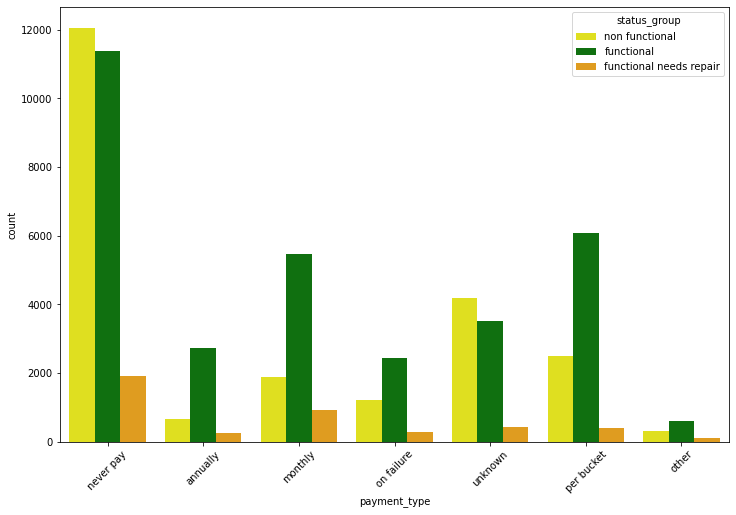

In [28]:
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot(x = 'payment_type', hue = 'status_group', data = df, ax = ax, palette = color_status)
plt.xticks(rotation = 45)

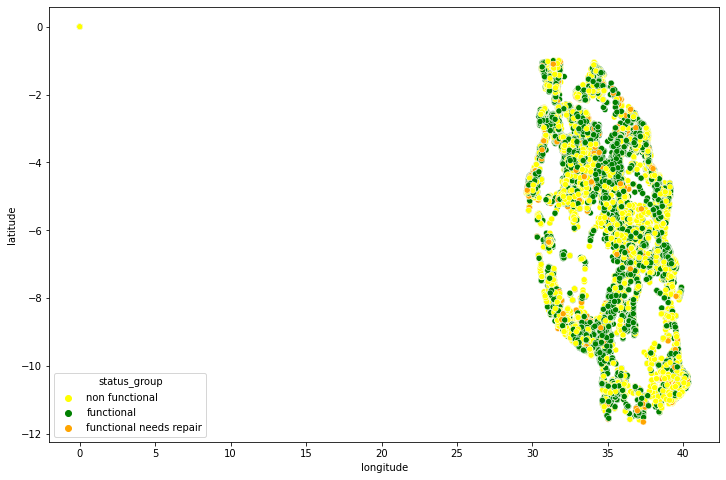

In [29]:
fig,ax = plt.subplots(figsize = (12,8))
sns.scatterplot(x = 'longitude', y = 'latitude', data = df, hue = 'status_group', ax = ax, palette = color_status)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

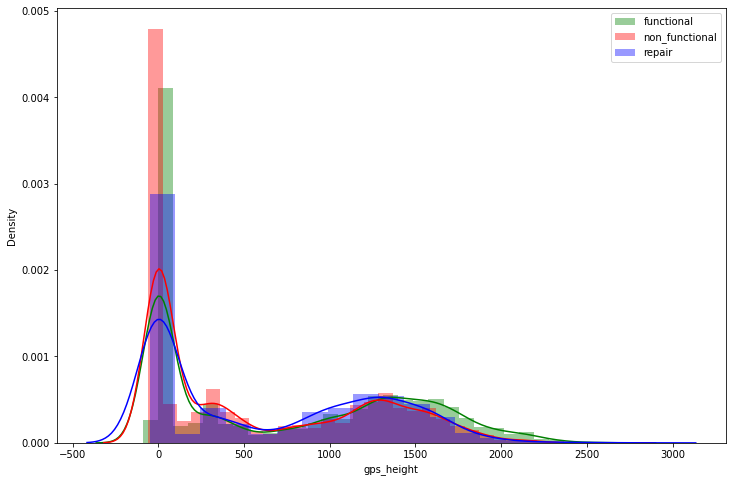

In [30]:
row_functional = (df['status_group'] == 'functional')
row_non_functional = (df['status_group'] == 'non functional')
row_repair = (df['status_group'] == 'functional needs repair')
col = 'gps_height'
fig,ax = plt.subplots(figsize = (12,8))
sns.distplot(df[col][row_functional], color = 'green', label = 'functional', ax = ax)
sns.distplot(df[col][row_non_functional], color = 'red', label = 'non_functional', ax = ax)
sns.distplot(df[col][row_repair], color = 'blue', label = 'repair', ax = ax)
plt.legend()